# Homework 1: Phase Unwrapping

- *Haotian Hong*
- *ID: 2023291007*

### Requirements:

1. Use the gradient-echo field mapping sequence to scan your head with and without SH shimming.
2. Process the data to get the field map in the unit of ppm.
3. Compare the field map before and after SH shim.

### Data Acquisition

Obtain the dicom files from the scanner

```
data
├─gre_fieldmap_1.0mm_no_shim_B0Map_203
├─gre_fieldmap_1.0mm_no_shim_Echo1_201
├─gre_fieldmap_1.0mm_no_shim_Echo2_202
├─gre_fieldmap_1.0mm_shim_B0Map_303
├─gre_fieldmap_1.0mm_shim_Echo1_301
└─gre_fieldmap_1.0mm_shim_Echo2_302
```

### Data Preprocessing

#### Load required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydicom import read_file
from skimage.restoration import unwrap_phase
from scipy.ndimage import gaussian_filter
import cv2 as cv
import os

#### Define required functions

- load_scan(path) - Load dicom files from the specified path
- generate_brain_msk(img) - Generate brain mask from the magnitude image

***Noting that I refuse to install FSL or convert dicom to nifty files to process the data in this homework. I will use the raw dicom files to process the data.***

In [2]:
# Load dicom files
def load_scan(path):
    slices = [read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

The brain mask is generated with traditional digital image processing methods by thresholding, morphological and flood fill operations.

In [3]:
# Generate brain mask
def generate_brain_msk(img):
    msk = img>280
    for i,slice in enumerate(msk):
        slice = cv.erode(slice.astype(np.uint8), np.ones((3,7), np.uint8), iterations=3)
        ret, markers = cv.connectedComponents(slice)
        marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
        largest_component = np.argmax(marker_area)+1
        slice = (markers==largest_component)
        slice = cv.dilate(slice.astype(np.uint8), np.ones((2,4), np.uint8), iterations=3)
        msk_bck = np.zeros((slice.shape[0]-2,slice.shape[1]-2), np.uint8)
        cv.floodFill(msk_bck, slice, (0,0), 255)
        slice = np.zeros_like(slice)
        slice[1:-1,1:-1] = cv.bitwise_not(msk_bck)
        msk[i] = slice!=0
    return msk

#### Load dicom files and generate brain mask

Though the mask generated from the magnitude image of the field map is not that perfect, it is enough for the following unwrapping and susceptibility calculation.

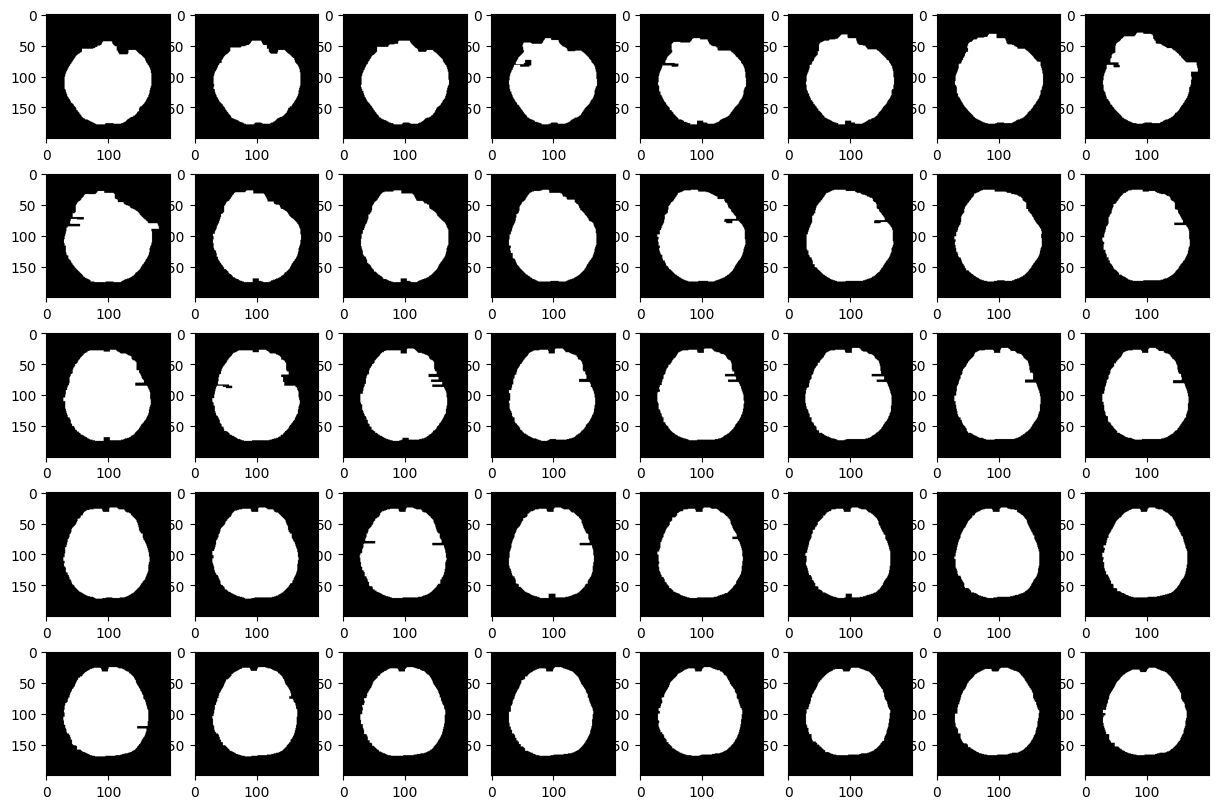

In [4]:
# Load dicom files
dcm_noshim = load_scan('data\gre_fieldmap_1.0mm_no_shim_B0Map_203')
dcm_shim = load_scan('data\gre_fieldmap_1.0mm_shim_B0Map_303')
dcm_echo1 = load_scan('data\gre_fieldmap_1.0mm_no_shim_Echo1_201')

B0_noshim = np.stack([s.pixel_array for s in dcm_noshim]).astype(float)
B0_shim = np.stack([s.pixel_array for s in dcm_shim]).astype(float)
data_echo1 = np.stack([s.pixel_array for s in dcm_echo1])

# Obtian mask for brain
msk = generate_brain_msk(data_echo1)

plt.figure(figsize=(15,10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.imshow(msk[i], cmap='gray')
plt.show()

#### Apply the mask to the field map and convert it to phase map

Knowing that the phase stored in the dicom files is quantized, we need to convert it to the real phase value by multiplying it with the phase scale factor.

$$PhaseMap = \cfrac{B0Map}{2\pi}\cdot\cfrac{2\pi}{4096}$$

where $\frac{B0Map}{2\pi}$ denotes the dicom data we got from the machine, 4096 is the quantization level of the phase.

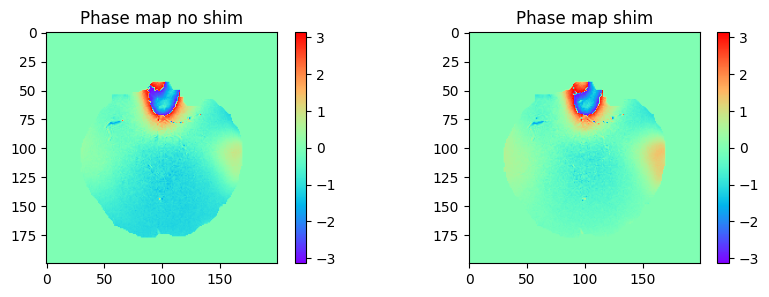

In [5]:
# Apply the mask
B0_noshim*=msk
B0_shim*=msk

# Convert B0 maps to phase maps
phase_msk_noshim = B0_noshim*np.pi/4096
phase_msk_shim = B0_shim*np.pi/4096

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(phase_msk_noshim[1], cmap='rainbow')
plt.colorbar()
plt.title('Phase map no shim')
plt.subplot(1,2,2)
plt.imshow(phase_msk_shim[1], cmap='rainbow')
plt.colorbar()
plt.title('Phase map shim')
plt.show()

#### Phase Unwrapping

It's apparent that the phase map plotted above is wrapped. We need to unwrap it to get the real phase value. The unwrapping algorithm is from the `skimage` library.

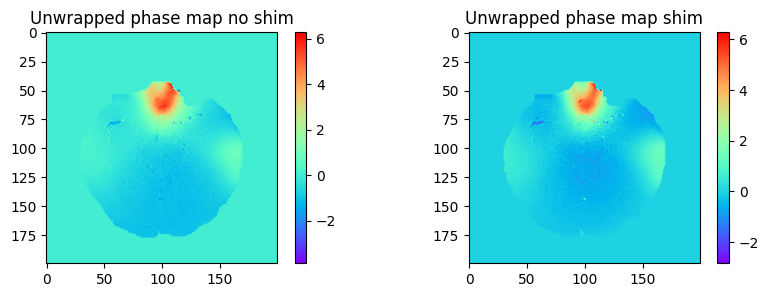

In [6]:
# Unwrap the phase maps
phase_msk_uw_noshim = unwrap_phase(phase_msk_noshim)
phase_msk_uw_shim = unwrap_phase(phase_msk_shim)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(phase_msk_uw_noshim[1], cmap='rainbow')
plt.colorbar()
plt.title('Unwrapped phase map no shim')
plt.subplot(1,2,2)
plt.imshow(phase_msk_uw_shim[1], cmap='rainbow')
plt.colorbar()
plt.title('Unwrapped phase map shim')
plt.show()

#### Calculate the susceptibility map

Given that the phase shift $\Delta \Phi = 2\pi \gamma \Delta B_0\Delta TE$

The susceptibility map is calculated by the following formulas:

$$\Delta B_0 = \cfrac{PhaseMap}{2\pi\cdot\gamma \Delta TE}$$
$$\mu(\text{susceptibility}, ppm) = \cfrac{\Delta B_0}{B_0}\cdot 10^{6}$$

where $\Delta TE$ is the echo time difference between the two echoes which could be obtained from the dicom files, $\gamma$ is the gyromagnetic ratio of the proton, $B_0$ is the magnetic field strength.

The contour-plot images below show the susceptibility map of the head before and after SH shimming.

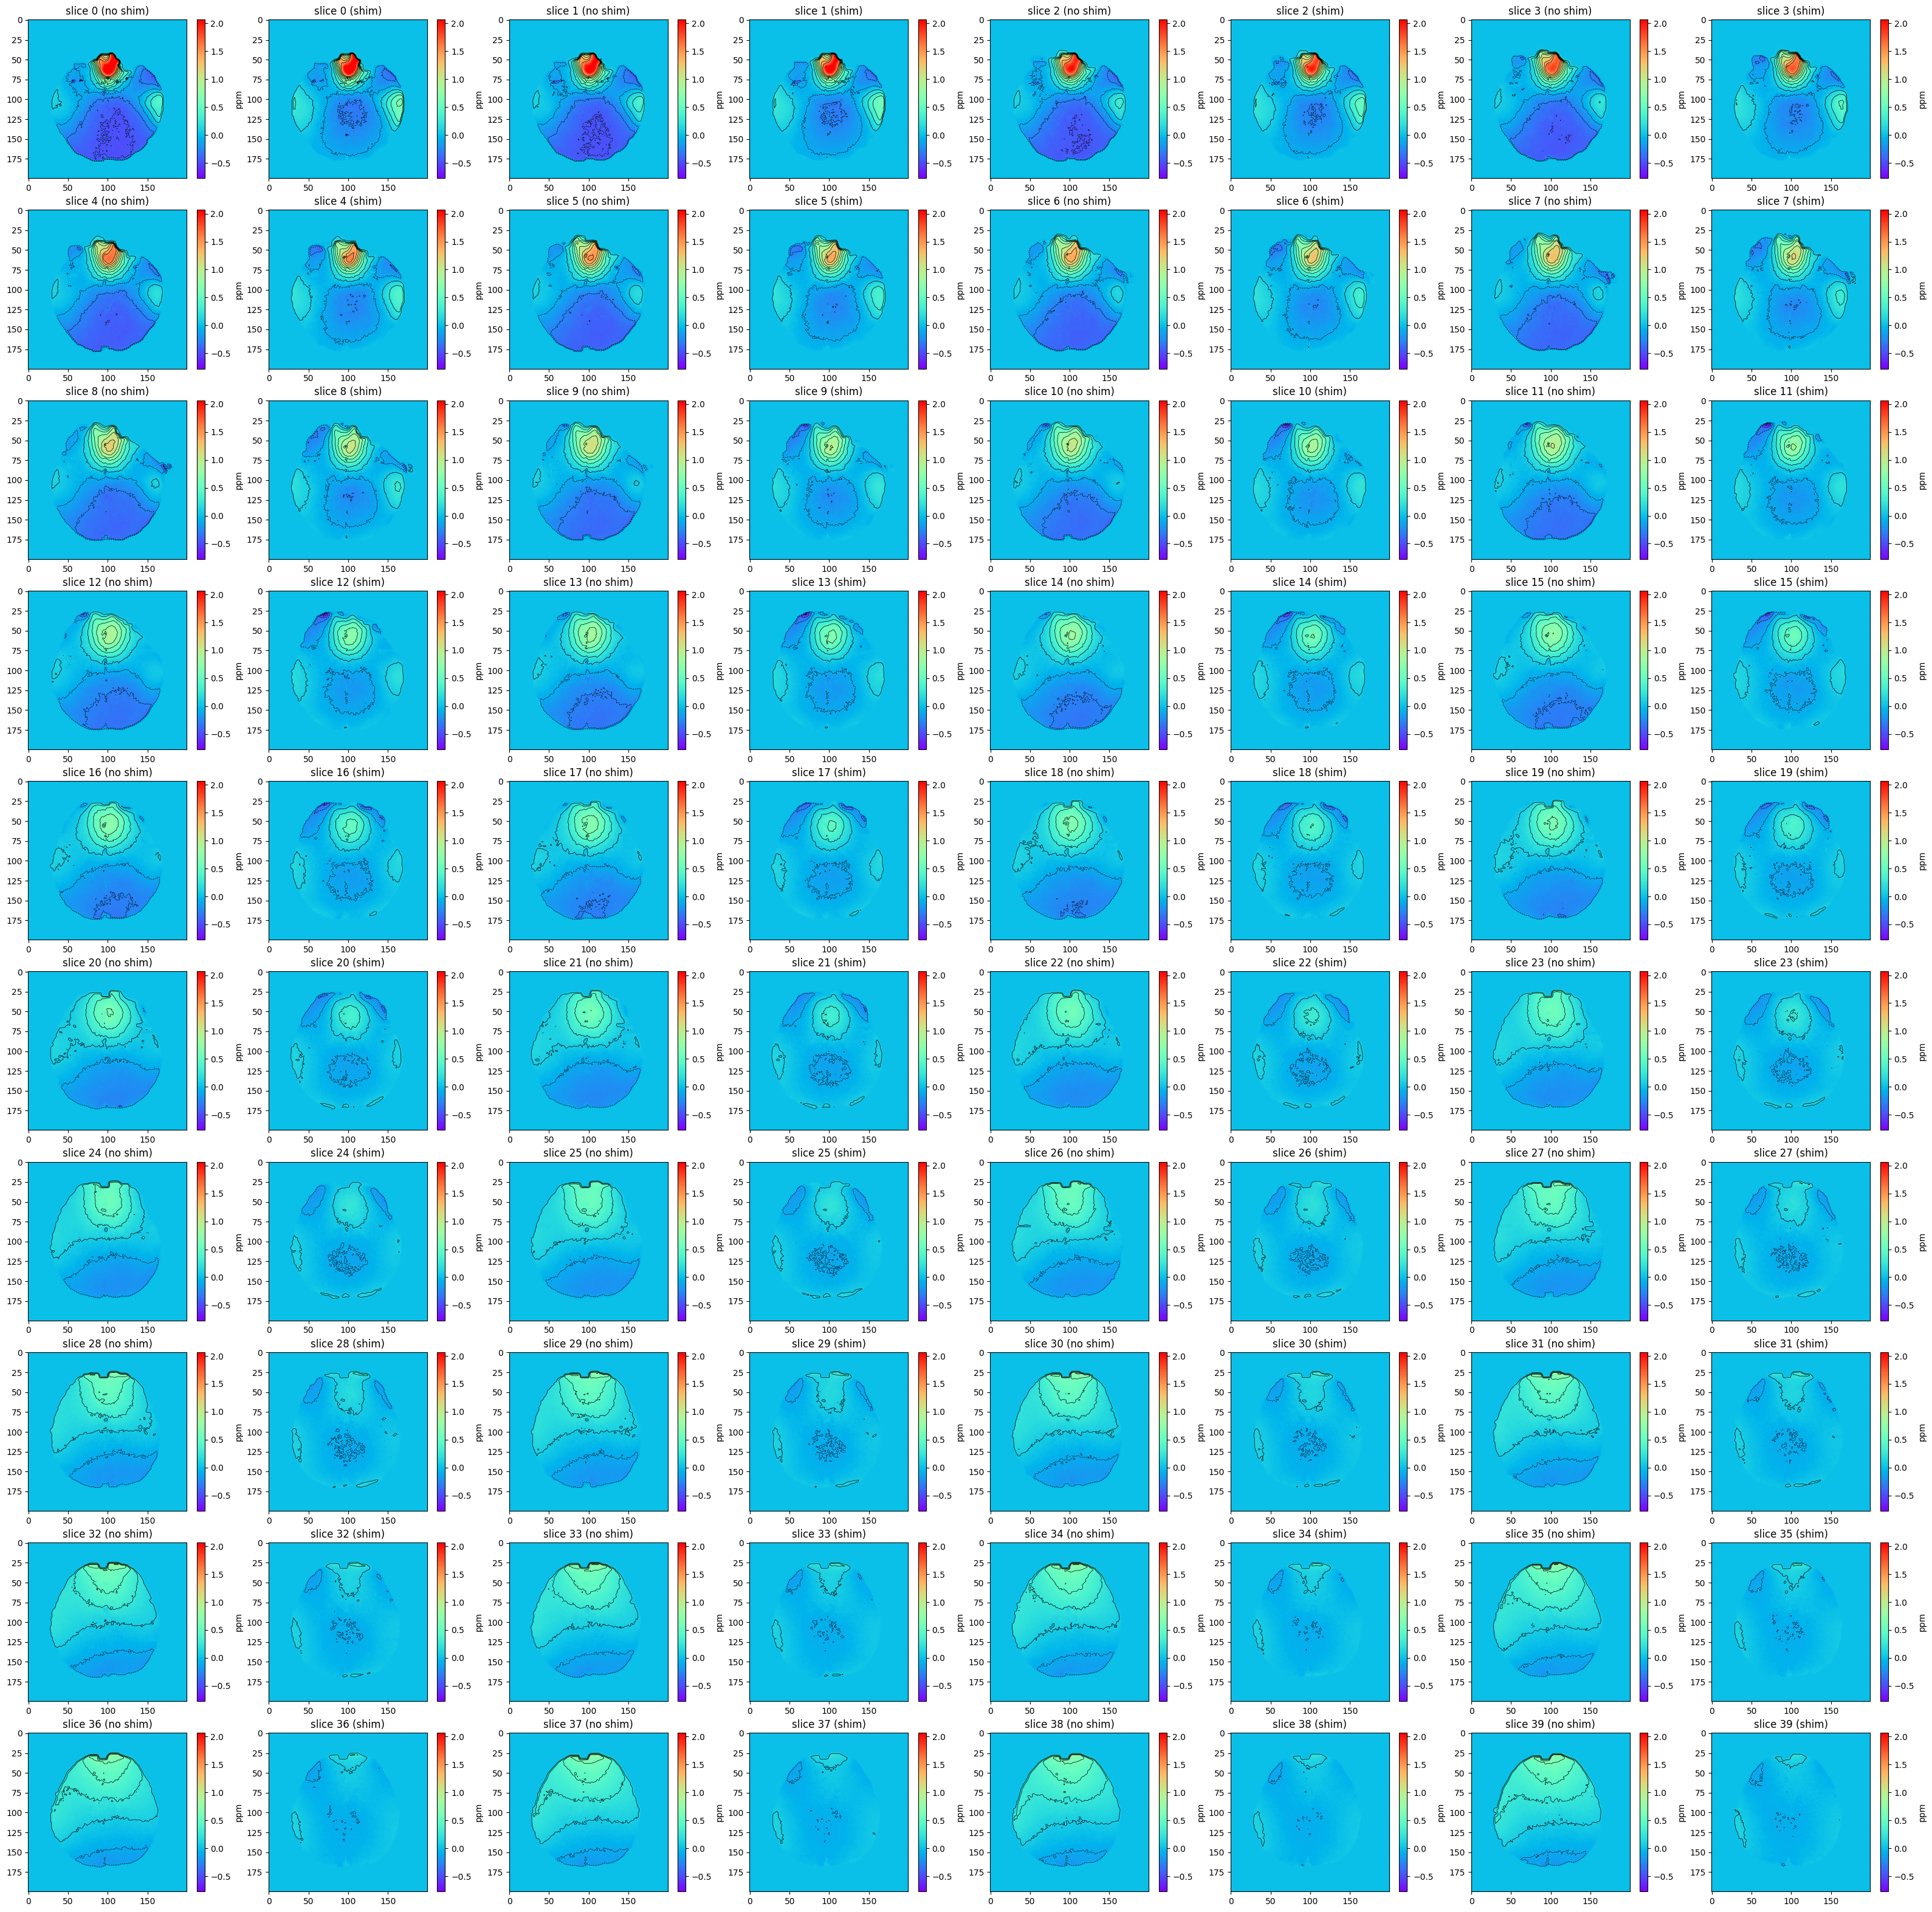

In [7]:
# Obtain dTE

TE1 = read_file('data/gre_fieldmap_1.0mm_no_shim_Echo1_201/00000001.dcm').EchoTime # ms
TE2 = read_file('data/gre_fieldmap_1.0mm_no_shim_Echo2_202/00000001.dcm').EchoTime # ms 
dTE = (TE2-TE1)*1e-3 #s

# Calculate field map
gamma = 42.58e6 # Hz/T
dB0_no_shim = phase_msk_uw_noshim/(2*np.pi*dTE*gamma) # 
dB0_shim = phase_msk_uw_shim/(2*np.pi*dTE*gamma)

# Calculate susceptibility map
B0 = 3 # T
mu_no_shim = dB0_no_shim/B0*1e6
mu_shim = dB0_shim/B0*1e6

# Plot the susceptibility maps (filter it to improve contour visualization)
mu_no_shim = gaussian_filter(mu_no_shim, sigma=0.7) 
mu_shim = gaussian_filter(mu_shim, sigma=0.7)
plt.figure(figsize=(40,40))
for i in range(40):
    plt.subplot(10,8,1+i*2)
    plt.imshow(mu_no_shim[i], cmap='rainbow')
    plt.clim(min(mu_shim.min(), mu_no_shim.min()),max(mu_shim.max(), mu_no_shim.max())*.8)
    plt.colorbar(label='ppm')
    plt.contour(mu_no_shim[i], levels=np.linspace(-1,1.5,15), linewidths=0.5, colors='black')
    plt.title('slice {} (no shim)'.format(i))
    plt.subplot(10,8,2+i*2)
    plt.imshow(mu_shim[i], cmap='rainbow')
    plt.clim(min(mu_shim.min(), mu_no_shim.min()),max(mu_shim.max(), mu_no_shim.max())*.8)
    plt.colorbar(label='ppm')
    plt.contour(mu_shim[i],  levels=np.linspace(-1,1.5,15), linewidths=0.5, colors='black')
    plt.title('slice {} (shim)'.format(i))
plt.show()

### Susceptibility evaluation

The histogram of susceptibility map for image with and without shimming is plotted to evaluate the field inhomogeneity.

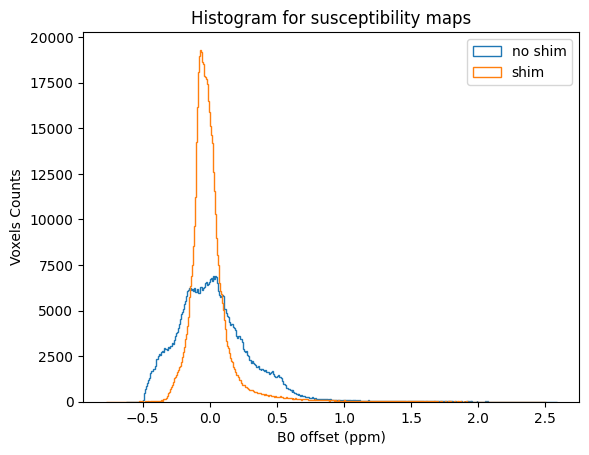

In [8]:
mu_no_shim[msk==0] = np.nan
mu_shim[msk==0] = np.nan

plt.hist(mu_no_shim.flatten(),bins=500,histtype='step',label='no shim')
plt.hist(mu_shim.flatten(),bins=500,histtype='step',label='shim')
plt.xlabel('B0 offset (ppm)')
plt.ylabel('Voxels Counts')
plt.title("Histogram for susceptibility maps")
plt.legend()
plt.show()

#### Conclusion

The susceptibility map of the head after SH shimming is more uniform than that before SH shimming. Based on the histogram plot above, the susceptibility value of the head after SH shimming is more concentrated around 0 ppm, which means the field homogeneity is improved by SH shimming.

In [9]:
from scipy.io import savemat
from einops import rearrange
def load_pos(path):
    slices = [read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    pixel_size = slices[0].PixelSpacing
    data = rearrange(np.asarray([s.pixel_array for s in slices]),"Z X Y -> X Y Z")
    slice_loc = [float(str(s.SliceLocation)) for s in slices]
    X,Y,Z = np.zeros((3,)+data.shape)
    for i,j,k in np.ndindex(data.shape):
        X[i,j,k] = (i-data.shape[0]//2)*pixel_size[0]
        Y[i,j,k] = (j-data.shape[1]//2)*pixel_size[1]
        Z[i,j,k] = slice_loc[k]
    # Normalize to m
    X/=1000
    Y/=1000
    Z/=1000
    print(X.min(),X.max())
    print(Y.min(),Y.max())
    print(Z.min(),Z.max())
    savemat('B0_map.mat', {'B0_no_shim':mu_no_shim, 'B0_shim':mu_shim, 'X':X, 'Y':Y, 'Z':Z}, do_compression=False)

load_pos('data\gre_fieldmap_1.0mm_no_shim_B0Map_203')

-0.1 0.099
-0.1 0.099
-0.0205162907 0.020433723400000003
